In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from transformers import RobertaTokenizerFast, RobertaModel
import torch
from utils import *
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.nn import functional as F


In [2]:
# Load X_train and y_train, X_val and y_val from pickle files
X_train = pd.read_pickle('X_train.pkl')
y_train = pd.read_pickle('y_train.pkl')
X_val = pd.read_pickle('X_val.pkl')
y_val = pd.read_pickle('y_val.pkl')

In [3]:
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')
train_encodings = tokenizer(
    X_train['cleaned_body'].tolist(),
    padding=True,
    truncation=True,
    return_token_type_ids=False,
    max_length=256,
    return_tensors='pt',
)

val_encodings = tokenizer(
    X_val['cleaned_body'].tolist(),
    padding=True,
    truncation=True,
    return_token_type_ids=False,
    max_length=256,
    return_tensors='pt',
)

In [4]:
X_train.drop(columns=['cleaned_body'], inplace=True)
X_val.drop(columns=['cleaned_body'], inplace=True)

In [5]:
# Model parameters
batch_size = 32
num_labels = 2

# Set device if cuda is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [6]:
train_dataset = TransformerDataset(train_encodings, y_train)
val_dataset = TransformerDataset(val_encodings, y_val)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# Define model and training parameters
num_epochs = 500
criterion = CrossEntropyLoss()

model = TransformerModel(num_labels)
torch.cuda.empty_cache()
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
learning_rate_scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataloader) * num_epochs
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
# Training Loop

train_losses,val_losses,train_accuracies,val_accuracies = [],[],[],[]
train_recalls,val_recalls = [],[]


best_model = model
best_loss = 99999
best_accuracy = 0
train_best_loss = 99999
train_best_accuracy = 0

for epoch in tqdm(range(num_epochs)):

    ######## TRAINING #########
    train_accuracy, train_loss, val_accuracy, val_loss = 0, 0, 0, 0
    train_recall, val_recall = 0, 0

    model.train()
    optimizer.zero_grad()
    for batch in train_dataloader:
        input_ids = batch['input_ids'].squeeze(1).to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        logits,predictions = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # batch_loss = criterion(logits, labels)
        batch_loss = criterion(logits,labels)
        train_loss += batch_loss.item()
        
        train_accuracy += accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        train_recall += recall_score(labels.cpu().numpy(), predictions.cpu().numpy())

        # Backward pass
        batch_loss.backward()
        optimizer.step()
        # learning_rate_scheduler.step()

    train_losses.append(train_loss/len(train_dataloader))
    train_accuracies.append(train_accuracy/len(train_dataloader))

    ######## VALIDATION #########
    model.eval()
    for batch in val_dataloader:
        input_ids = batch['input_ids'].squeeze(1).to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits,predictions = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # batch_loss = criterion(logits, labels)
        batch_loss = criterion(logits,labels)
        val_loss += batch_loss.item()
        predictions = logits.argmax(dim=1)
        val_accuracy += accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())

    if val_loss < best_loss:
        best_loss = val_loss/len(val_dataloader)
        best_accuracy = val_accuracy/len(val_dataloader)
        train_best_accuracy = train_accuracy/len(train_dataloader)
        train_best_loss = train_loss/len(train_dataloader)
        best_model = model

    val_losses.append(val_loss/len(val_dataloader))
    val_accuracies.append(val_accuracy/len(val_dataloader))

print(f'Train Loss: {train_best_loss}')
print(f'Train Accuracy: {train_best_accuracy}')

print(f'Validation Loss: {best_loss}')
print(f'Validation Accuracy: {best_accuracy}')
print('\n')




100%|██████████| 500/500 [10:32<00:00,  1.27s/it]

Train Loss: 0.6911501799310956
Train Accuracy: 0.5767857142857142
Validation Loss: 0.6894811391830444
Validation Accuracy: 0.571875




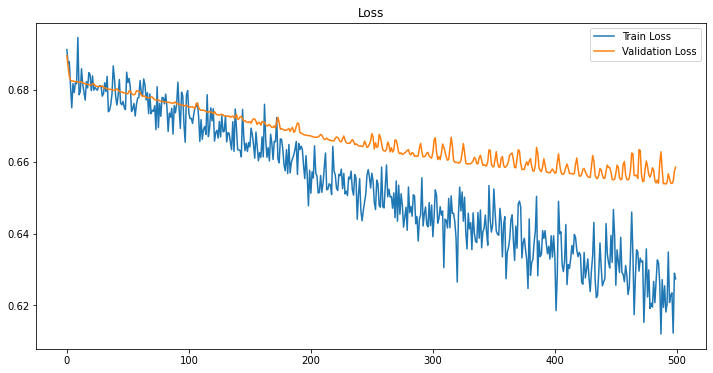

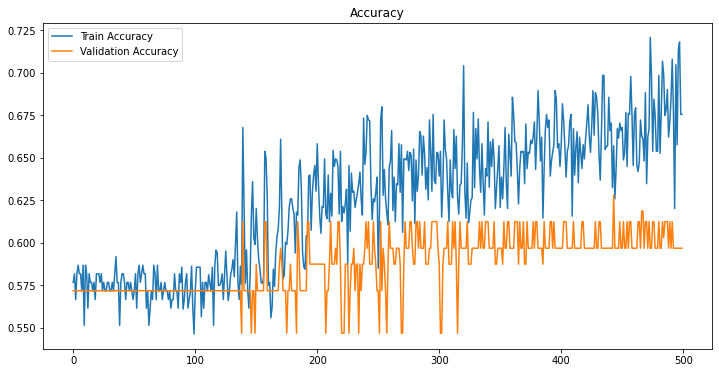

In [10]:
# Plot triain and validation metrics
plt.figure(figsize=(12,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()
 

In [9]:
# Save the transformer model
best_model.to('cpu')
torch.save(best_model, '.best_classifiers.pt')

In [8]:
best_model = torch.load('.best_classifiers.pt')

In [9]:
# device = "cpu"
# Now we unfreeze the model and train it again on 4 epochs to fine tune RoBERTa, if we had more data, we could train it for more epochs
num_epochs = 4
best_model.to(device)
model = TunedTransformerModel(transformer_model=best_model)
model.to(device)
linearlayer = LinearLayer(768, num_labels)
linearlayer.to(device)
criterion = CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
learning_rate_scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataloader) * num_epochs
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
# Training Loop

train_losses,val_losses,train_accuracies,val_accuracies = [],[],[],[]
train_recalls,val_recalls = [],[]

best_model_2 = model
best_loss = 99999
best_accuracy = 0
train_best_loss = 99999
train_best_accuracy = 0


for epoch in tqdm(range(num_epochs)):

    ######## TRAINING #########
    train_accuracy, train_loss, val_accuracy, val_loss = 0, 0, 0, 0

    model.train()
    optimizer.zero_grad()
    for batch in train_dataloader:
        input_ids = batch['input_ids'].squeeze(1).to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        out = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Apply Linear Layer
        fc = linearlayer(out)

        # Apply softmax to get probabilities
        logits = torch.softmax(fc, dim=1)
        predictions = torch.argmax(logits, dim=1)

        # batch_loss = criterion(logits, labels)
        batch_loss = criterion(logits,labels)
        train_loss += batch_loss.item()
        
        train_accuracy += accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())

        # Backward pass
        batch_loss.backward()
        optimizer.step()
        # learning_rate_scheduler.step()

    train_losses.append(train_loss/len(train_dataloader))
    train_accuracies.append(train_accuracy/len(train_dataloader))

    ######## VALIDATION #########
    model.eval()
    for batch in val_dataloader:
        input_ids = batch['input_ids'].squeeze(1).to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        out = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Apply Linear Layer
        fc = linearlayer(out)

        # Apply softmax to get probabilities
        logits = torch.softmax(fc, dim=1)
        predictions = torch.argmax(logits, dim=1)


        # batch_loss = criterion(logits, labels)
        batch_loss = criterion(logits,labels)
        val_loss += batch_loss.item()
        predictions = logits.argmax(dim=1)
        val_accuracy += accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())

    val_losses.append(val_loss/len(val_dataloader))
    val_accuracies.append(val_accuracy/len(val_dataloader))

    if val_loss < best_loss:
        best_loss = val_loss/len(val_dataloader)
        best_accuracy = val_accuracy/len(val_dataloader)
        train_best_accuracy = train_accuracy/len(train_dataloader)
        train_best_loss = train_loss/len(train_dataloader)
        best_model_2 = model

print(f'Train Loss: {train_best_loss}')
print(f'Train Accuracy: {train_best_accuracy}')

print(f'Validation Loss: {best_loss}')
print(f'Validation Accuracy: {best_accuracy}')
print('\n')

    

100%|██████████| 4/4 [00:12<00:00,  3.19s/it]

Train Loss: 0.6947512371199471
Train Accuracy: 0.43720238095238095
Validation Loss: 0.692037433385849
Validation Accuracy: 0.6125




In [11]:
# Save model
best_model.to('cpu')
torch.save(best_model_2, '.tuned_transformer.pt')

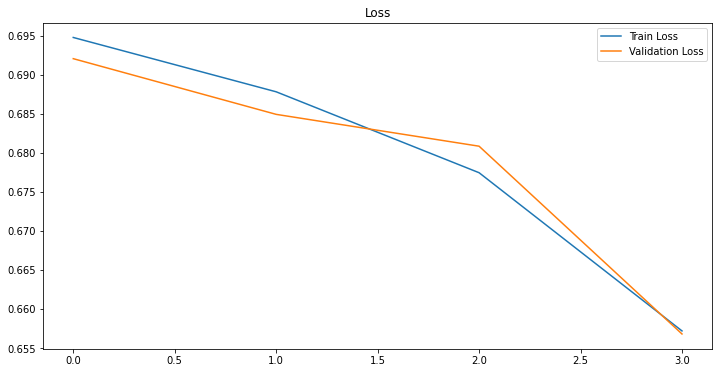

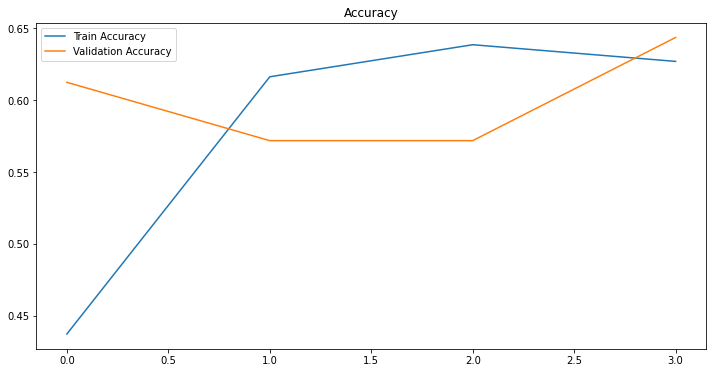

In [12]:
# Plot triain and validation metrics
plt.figure(figsize=(12,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()
 